In [24]:

import re
import statistics as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os

!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

# Define device
device = 'cuda' if len(tf.config.experimental.list_physical_devices('GPU')) > 0 else 'cpu'
print(f"Using device: {device}")

Num GPUs Available:  1
Using device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mrmorj/hate-speech-and-offensive-language-dataset")

print("Path to dataset files:", path)
print("Files in dataset directory:", os.listdir(path))

Using Colab cache for faster access to the 'hate-speech-and-offensive-language-dataset' dataset.
Path to dataset files: /kaggle/input/hate-speech-and-offensive-language-dataset
Files in dataset directory: ['labeled_data.csv']


In [16]:
from IPython.display import display
data = pd.read_csv(path + '/labeled_data.csv')
print("dataset head:")
display(data.head())
print("dataset info:")
data.info()


dataset head:


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [19]:
data_cleaned = data.drop(columns = ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'])
data_cleaned.rename(columns = {'class':'label'}, inplace=True)

label_mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
data_cleaned['label'] = data_cleaned['label'].map(label_mapping)

print("Cleaned dataset head:")
print(data_cleaned.head())
print("Cleaned dataset info:")
data_cleaned.info()
print("Value counts for labels:")
print(data_cleaned['label'].value_counts())

Cleaned dataset head:
                label                                              tweet
0             neither  !!! RT @mayasolovely: As a woman you shouldn't...
1  offensive_language  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2  offensive_language  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3  offensive_language  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4  offensive_language  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   24783 non-null  object
 1   tweet   24783 non-null  object
dtypes: object(2)
memory usage: 387.4+ KB
Value counts for labels:
label
offensive_language    19190
neither                4163
hate_speech            1430
Name: count, dtype: int64


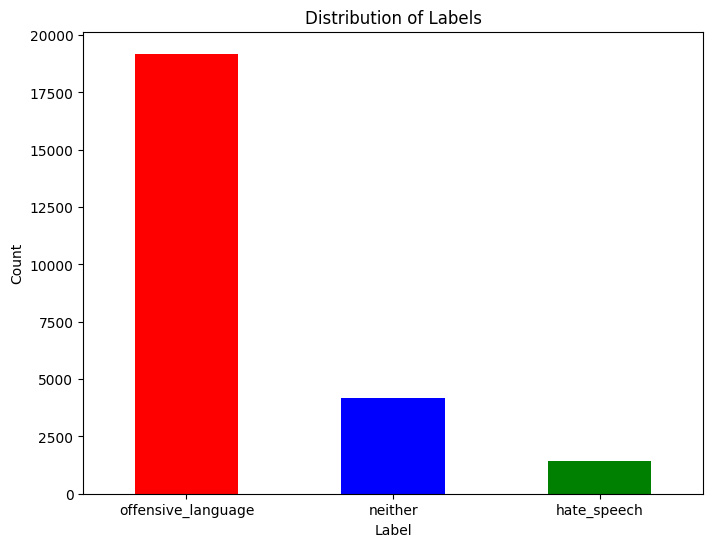

In [20]:
plt.figure(figsize=(8,6))
data_cleaned['label'].value_counts().plot(kind='bar', color = ['red', 'blue', 'green'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [23]:
stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords]  # Remove stopwords and non-alphabetic tokens
    return ' '.join(filtered_tokens)
data_cleaned['tweet'] = data_cleaned['tweet'].apply(clean_text)

print('Data after cleaning:')
print(data_cleaned.head())

Data after cleaning:
                label                                              tweet
0             neither  rt woman complain cleaning house amp man alway...
1  offensive_language  rt boy dats cold tyga dwn bad cuffin dat hoe p...
2  offensive_language  rt dawg rt ever fuck bitch start cry confused ...
3  offensive_language                                rt look like tranny
4  offensive_language  rt shit hear might true might faker bitch told ya


Data after augmentation:
label
offensive_language    19190
hate_speech            5708
neither                4163
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels After Augmentation')

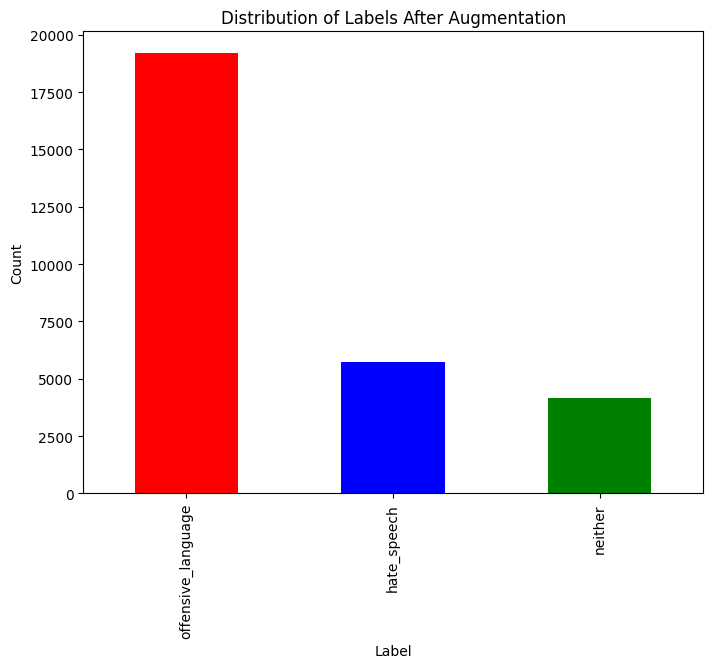

In [26]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def augment_text(text, num_augments=1):
    word = text.split()
    augment_text = []
    
    for i in range(num_augments):
        new_words = list(word)
        
        if not new_words:
            continue
        
        random_word_index = np.random.randint(0, len(new_words))
        random_word = new_words[random_word_index]
        
        synonyms = get_synonyms(random_word)
        if synonyms:
            random_synonym = np.random.choice(synonyms)
            new_words[random_word_index] = random_synonym
            
        augment_text.append(' '.join(new_words))
    return augment_text

hate_speech_data = data_cleaned[data_cleaned['label'] == 'hate_speech'].copy()

augment_samples = []
for index, row in hate_speech_data.iterrows():
    augmented_texts  = augment_text(row['tweet'], num_augments=3)
    for aug_text in augmented_texts :
        augment_samples.append({'tweet': aug_text, 'label': 'hate_speech'})
        
agument_df = pd.DataFrame(augment_samples)
data_augmented = pd.concat([data_cleaned, agument_df], ignore_index=True)

print("Data after augmentation:")
print(data_augmented['label'].value_counts())
plt.figure(figsize=(8,6))
data_augmented['label'].value_counts().plot(kind='bar', color = ['red', 'blue', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels After Augmentation')